In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
    utils
)

from scipy.stats import norm
import pandas as pd

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

# Autoencoder

In [2]:
def preprocess_fashion_mnist(
    images     , 
    scale      = 255.0, 
    pad_widths = ((0,0), (2,2), (2,2))
):
    r"""
    Fashion MNIST data contain 28x28 grayscale images (pixel values between 0 and 255)
    This method will scale the data by scale, pad the images, and add one dimension to
      the data (i.e., (n_images, 28, 28) to (n_images, 28, 28, 1)) to conform to normal 
      conventions for color images
    For autoencoder (specifically, Conv2D), we typically want to pad each image to 32x32, 
      hence the default pad_widths = ((0,0), (2,2), (2,2))
    """
    #-------------------------
    images = images.astype('float32')/scale
    images = np.pad(
        array           = images, 
        pad_width       = pad_widths, 
        constant_values = 0.0
    )
    images = np.expand_dims(images, -1)
    return images

In [68]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
#-------------------------
img_size_y, img_size_x = x_train.shape[1:]
img_n_channels         = 1
embed_n_dim            = 2
#-------------------------
x_train = preprocess_fashion_mnist(images = x_train)
x_test  = preprocess_fashion_mnist(images = x_test)

# Build encoder

In [5]:
# Build encoder
encoder_input = layers.Input(
    shape = (img_size_y, img_size_x, img_n_channels), 
    name  = 'encoder_input'
)
#-----
x = layers.Conv2D(
    filters     = 32, 
    kernel_size = (3,3), 
    strides     = 2, 
    activation  = 'relu', 
    padding     = 'same'
)(encoder_input)
#-----
x = layers.Conv2D(
    filters     = 64, 
    kernel_size = (3,3), 
    strides     = 2, 
    activation  = 'relu', 
    padding     = 'same'
)(x)
#-----
x = layers.Conv2D(
    filters     = 128, 
    kernel_size = (3,3), 
    strides     = 2, 
    activation  = 'relu', 
    padding     = 'same'
)(x)
#-----
shape_before_flattening = K.int_shape(x)[1:]
#-----
x = layers.Flatten()(x)
encoder_output = layers.Dense(embed_n_dim, name='encoder_output')(x)
#-----
encoder = models.Model(encoder_input, encoder_output)

In [6]:
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

# Build decoder

In [7]:
# Build decoder
decoder_input = layers.Input(
    shape = (embed_n_dim,), 
    name  = 'decoder_input'
)
#-----
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
#-----
x = layers.Conv2DTranspose(
    filters     = 128, 
    kernel_size = (3,3), 
    strides     = 2, 
    activation  = 'relu', 
    padding     = 'same'
)(x)
#-----
x = layers.Conv2DTranspose(
    filters     = 64, 
    kernel_size = (3,3), 
    strides     = 2, 
    activation  = 'relu', 
    padding     = 'same'
)(x)
#-----
x = layers.Conv2DTranspose(
    filters     = 32, 
    kernel_size = (3,3), 
    strides     = 2, 
    activation  = 'relu', 
    padding     = 'same'
)(x)
#-----
decoder_output = layers.Conv2D(
    filters     = img_n_channels, 
    kernel_size = (3,3), 
    strides     = 1, 
    activation  = 'sigmoid', 
    padding     = 'same', 
    name        = 'decoder_output'
)(x)
#-----
decoder = models.Model(decoder_input, decoder_output)

In [8]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

# Build autoencoder

In [9]:
# Join the encoder and decoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))

# Compile
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train
autoencoder.fit(
    x_train, 
    x_train, 
    epochs          = 5, 
    batch_size      = 100, 
    shuffle         = True, 
    validation_data = (x_test, x_test)
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 114ms/step - loss: 0.3789 - val_loss: 0.2656
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - loss: 0.2631 - val_loss: 0.2599
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 68s 114ms/step - loss: 0.2571 - val_loss: 0.2568
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - loss: 0.2536 - val_loss: 0.2552
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 60s 100ms/step - loss: 0.2523 - val_loss: 0.2530


# Reconstruct images

In [25]:
n_pred      = 5000
ex_imgs     = x_test[:n_pred]
ex_lbls     = y_test[:n_pred]
predictions = autoencoder.predict(ex_imgs)
embeddings = encoder.predict(ex_imgs)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


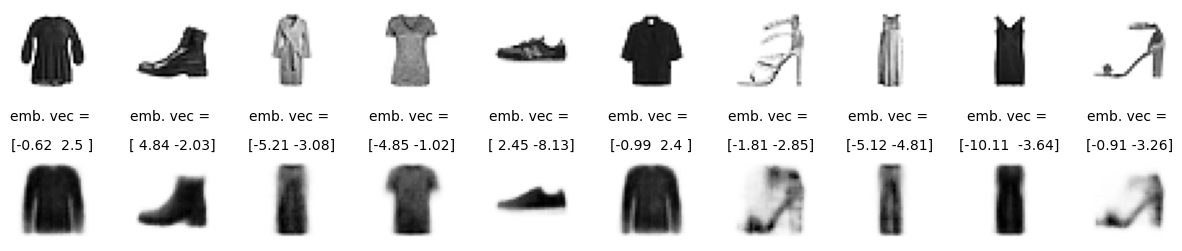

In [37]:
# display predictions of MLP against actual labels
n_to_show = 10
indices = np.random.choice(range(n_pred), n_to_show)

fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

for i,idx in enumerate(indices):
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, f"emb. vec = ",  fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.70, f"{np.round(embeddings[idx], decimals=2)}",  fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(ex_imgs[idx], cmap='Greys')
    #-----
    ax = fig.add_subplot(2, n_to_show, n_to_show+i+1)
    ax.axis('off')
    ax.imshow(predictions[idx], cmap='Greys')    

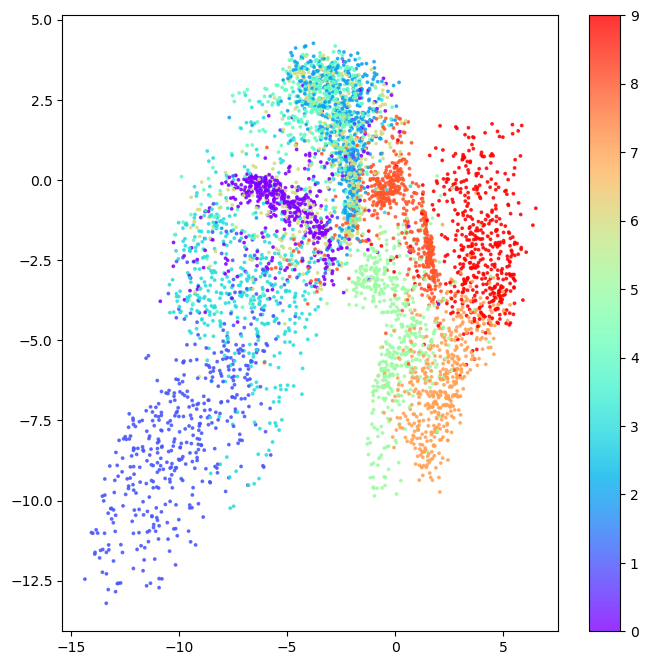

In [38]:
# Show the encoded points in 2D space
# Color the embeddings by their label

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap  = "rainbow",
    c     = ex_lbls,
    alpha = 0.8,
    s     = 3,
)
plt.colorbar()
plt.show()

# Generate new images

In [49]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, embed_n_dim)
)

In [50]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


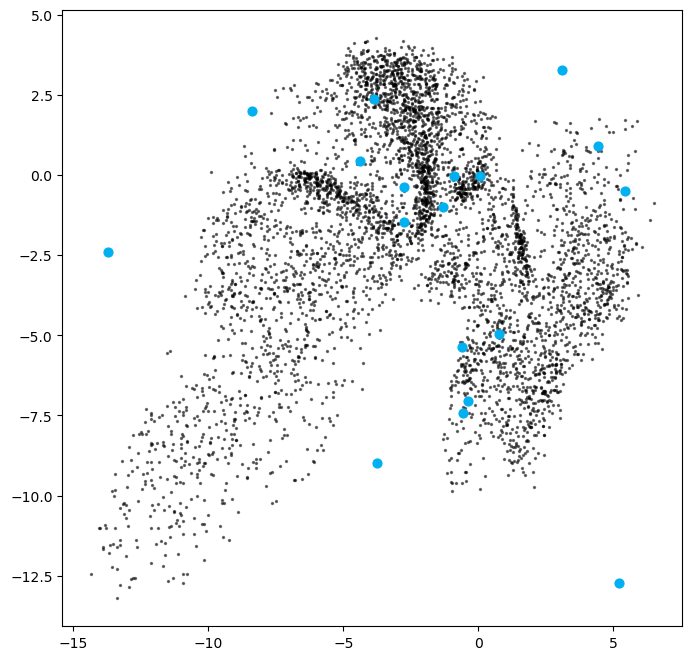

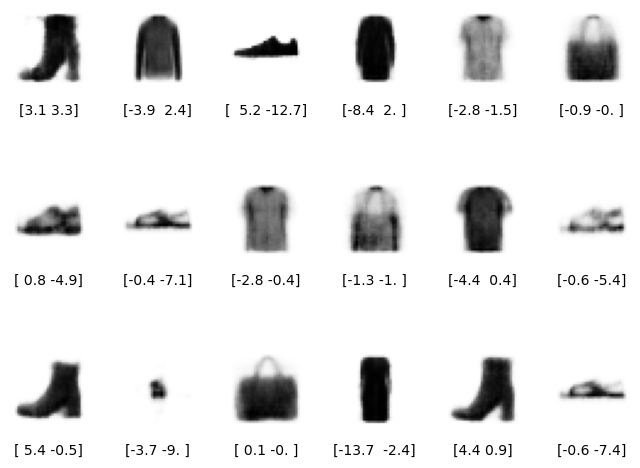

In [51]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


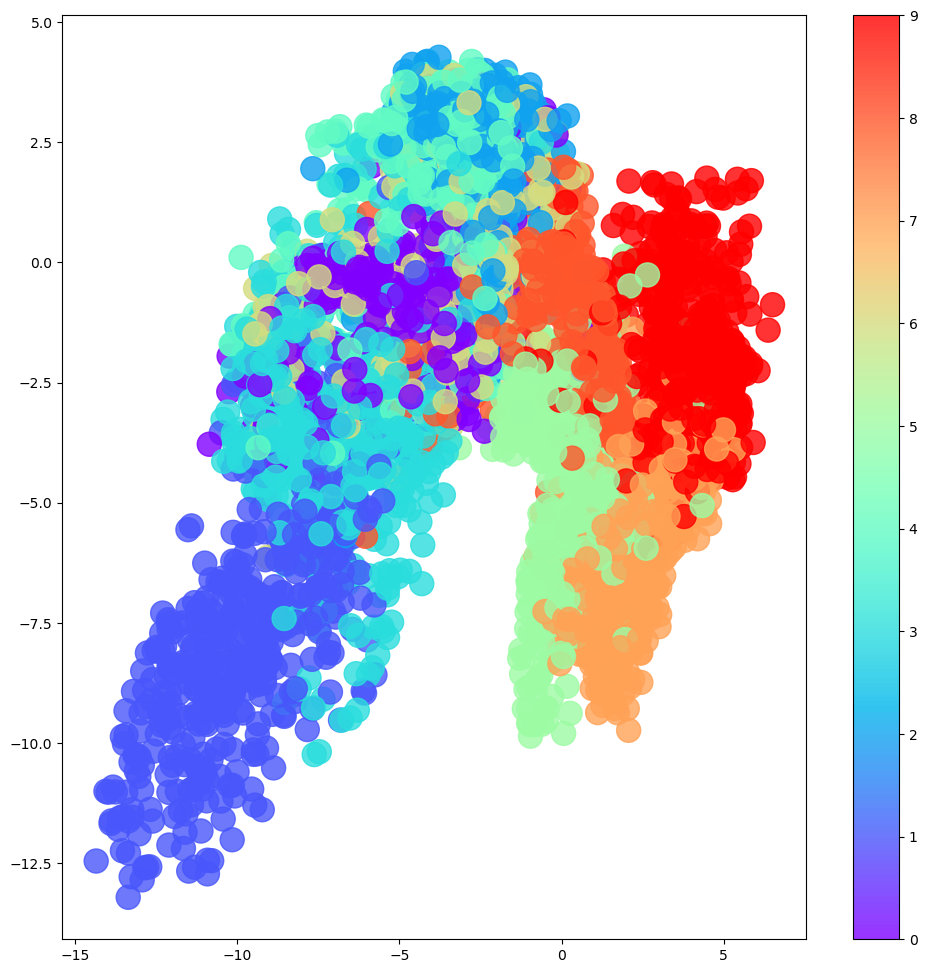

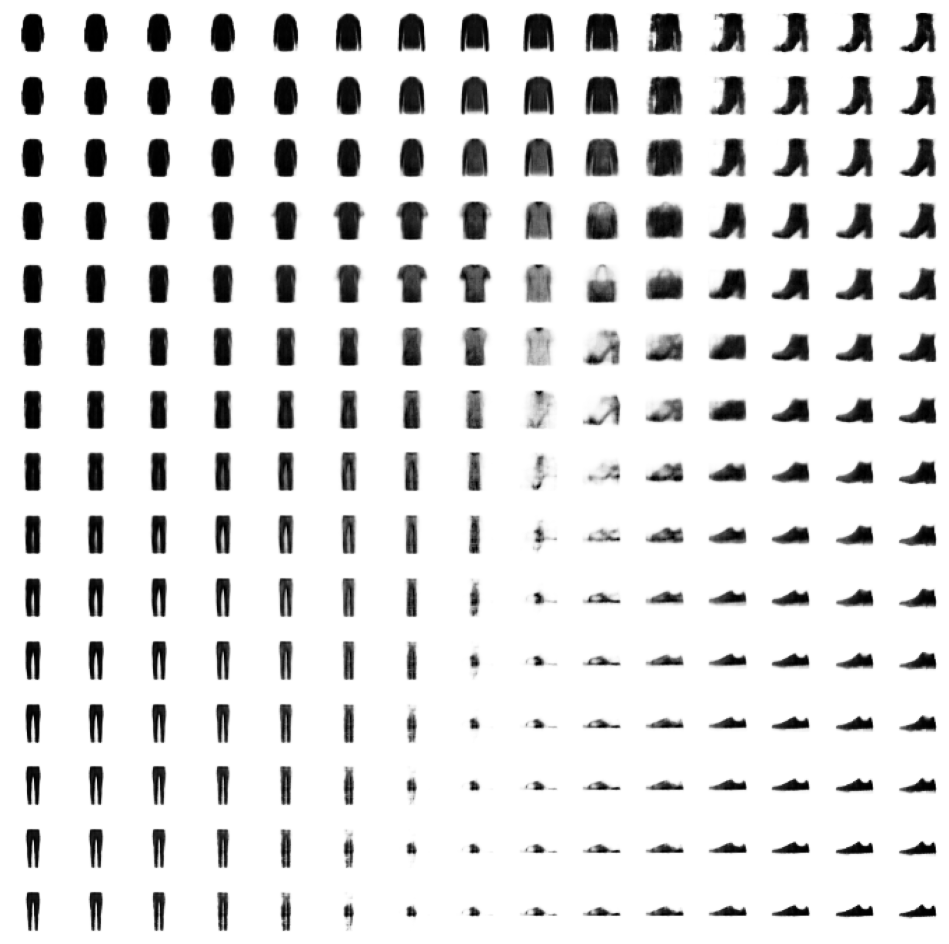

In [54]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=ex_lbls,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")